# Introduction

Looking at how Ice Cuber's solution tackles the problems.

In [1]:
import numpy as np
import json
from glob import glob
from pathlib import Path
import os
import random
import matplotlib.pyplot as plt
from   matplotlib import colors

from subprocess import Popen, PIPE, STDOUT
from glob import glob

# Helper Functions

In [2]:
def get_gridfile_as_numpy( imagefile ):
    """ convert the specified CSV file, containing a grid, to a numpy array """
    with open(imagefile, 'r') as file:
        data = file.read()

    arr = []
    rows = data.split('\n')
    for row in rows:
        list_of_integers = [int(item) for item in row.split(',')]
        arr.append(list_of_integers)

    return np.array(arr)

In [3]:
def mySystem(cmd):
    print(cmd)
    process = Popen(cmd, stdout=PIPE, stderr=STDOUT, shell=True)
    for line in iter(process.stdout.readline, b''):
        print(line.decode("utf-8"), end='')
    assert(process.wait() == 0)

In [4]:
def load_json(fpath):
    with open(fpath) as f:
        data = json.load(f)
    return data

In [5]:
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
      '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

In [6]:
# adapted from: https://www.kaggle.com/code/allegich/arc-2024-starter-notebook-eda
def plot_one(task, ax, i,train_or_test, input_or_output):

    input_matrix = task[train_or_test][i][input_or_output]
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True,which='both',color='lightgrey', linewidth=0.5)

    ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(train_or_test + ' '+input_or_output)

In [7]:
def show_attempts( train_id ):

  data = load_json('sub_icecube.json')

  n_samples = 2

  name = f'attempt_2'
  input_matrix = data[train_id][0][name]
  if len(input_matrix) > 0:
    fig, axs = plt.subplots(1, n_samples, figsize=(3*n_samples,3*2))
    for i in range(n_samples):

      name = f'attempt_{i+1}'
      input_matrix = data[train_id][0][name]
      if len(input_matrix) > 0 :

        ax = axs[i]
        ax.imshow(input_matrix, cmap=cmap, norm=norm)
        ax.grid(True,which='both',color='lightgrey', linewidth=0.5)

        ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
        ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(f"{train_id} - {name}")

    plt.tight_layout()
    plt.show()

  else:
    print("Only 1 attempt")
    fig, axs = plt.subplots(1, 1, figsize=(2,2))
    plot_one(data, axs, 0, train_id, 'attempt_1')
    plt.show()


In [8]:
def plot_sample(sample,train_id):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    n_samples = len(sample['train'])
    print('n samples', n_samples)
    print('train id %s, n_colors %s, shape in %s shape out %s'
              %(train_id, len(np.unique(sample['train'][0]['input']))-1,
               np.array(sample['train'][0]['input']).shape,
               np.array(sample['train'][0]['output']).shape))

    fig, axs = plt.subplots(2, n_samples, figsize=(3*n_samples,3*2))
    for i in range(n_samples):
        plot_one(sample, axs[0,i],i,'train','input')
        plot_one(sample, axs[1,i],i,'train','output')
    plt.tight_layout()
    plt.show()

    print('test img colors %s, shape %s'% (np.unique(sample['test'][0]['input']),
        np.array(sample['test'][0]['input']).shape))
    fig, axs = plt.subplots(1, 1, figsize=(2,2))
    plot_one(sample, axs, 0, 'test', 'input')
    plt.show()

In [9]:
def plot_single(grid_array,title):
    """
    Plots the supplied grid
    """
    fig, ax = plt.subplots(1, 1, figsize=(8,4))

    input_matrix = grid_array
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True,which='both',color='lightgrey', linewidth=0.5)

    ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(title)

    plt.show()

In [10]:
# Function to translate from old submission format (csv) to new one (json)
def translate_submission(file_path):
    # Read the original submission file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    submission_dict = {}

    for line in lines[1:]:  # Skip the header line
        output_id, output = line.strip().split(',')
        task_id, output_idx = output_id.split('_')
        predictions = output.split(' ')  # Split predictions based on ' '

        # Take only the first two predictions
        if len(predictions) > 2:
            predictions = predictions[:2]

        processed_predictions = []
        for pred in predictions:
            if pred:  # Check if pred is not an empty string
                pred_lines = pred.split('|')[1:-1]  # Remove empty strings from split
                pred_matrix = [list(map(int, line)) for line in pred_lines]
                processed_predictions.append(pred_matrix)

        attempt_1 = processed_predictions[0] if len(processed_predictions) > 0 else []
        attempt_2 = processed_predictions[1] if len(processed_predictions) > 1 else []

        if task_id not in submission_dict:
            submission_dict[task_id] = []

        attempt_dict = {
            "attempt_1": attempt_1,
            "attempt_2": attempt_2
        }

        if output_idx == '0':
            submission_dict[task_id].insert(0, attempt_dict)
        else:
            submission_dict[task_id].append(attempt_dict)

    # Write to the new json file
    with open('sub_icecube.json', 'w') as file:
        json.dump(submission_dict, file, indent=4)

# Test Some Example Problems

### Problem 1

n samples 2
train id f25ffba3, n_colors 4, shape in (10, 4) shape out (10, 4)


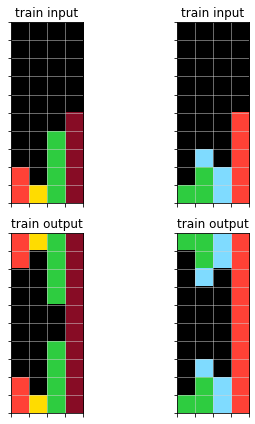

test img colors [0 1 3 4 7], shape (10, 4)


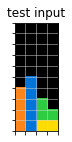

In [11]:
train_id = 'f25ffba3'
filepath = f"dataset/training/{train_id}.json"

data = load_json('../' + filepath)
plot_sample(data, train_id)

### 6: 1f85a75f

n samples 2
train id 1f85a75f, n_colors 3, shape in (30, 30) shape out (5, 3)


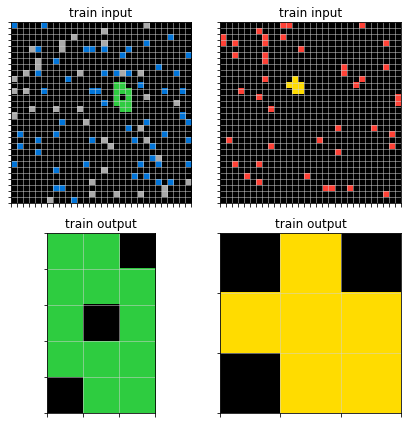

test img colors [0 1 2 3 8], shape (30, 30)


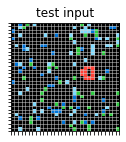

In [12]:
train_id = '1f85a75f'
filepath = f"dataset/training/{train_id}.json"

data = load_json('../' + filepath)
plot_sample(data, train_id)

### 7. 0d3d703e

n samples 4
train id 0d3d703e, n_colors 2, shape in (3, 3) shape out (3, 3)


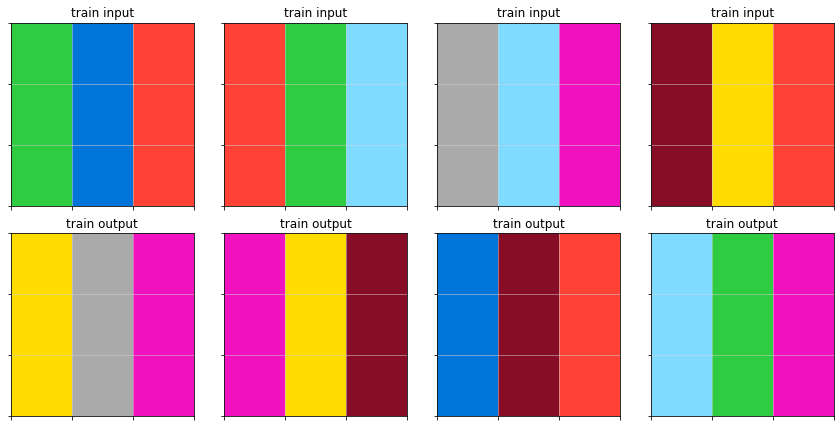

test img colors [1 3 8], shape (3, 3)


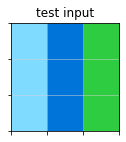

In [13]:
train_id = '0d3d703e'
filepath = f"dataset/training/{train_id}.json"

data = load_json('../' + filepath)
plot_sample(data, train_id)